In [1]:
import networkx as nx
import osmnx as ox
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from IPython.display import IFrame
from operator import attrgetter
import time
ox.config(log_console=True, use_cache=True)
import numpy 
import sys
from problem import PriorityQueue
numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive_service')
G = ox.project_graph(G)
## to be deleted
G = ox.graph_from_place(place, network_type='drive_service')
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)


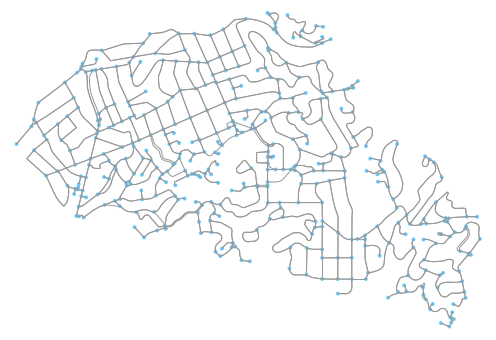

In [3]:
fig, ax = ox.plot_graph(G)

In [41]:
class Node:
    # TODO : __slots__ not __dict___ -- Optimization
    def __init__(self, node, osmid, distance = 0, parent = None):
        self.node = node
        self.distance = distance
        self.parent = parent
        self.osmid = osmid
        
        # I need this for dijkstra
        self.from_origin = self.distance_from_origin()
    
    # TODO : list comprehension -- Optimization
    def expand(self):
        children = [Node(G[child], child, distance = self.node[child][0]['length'], parent = self) \
                         for child in self.node]
        return children
    
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # TODO : better algorithm -- Optimization
    # I don't need to go to the parent to get the distance
    # every time I invoke the function
    
    def distance_from_origin(self):
        meters = 0
        node = self
        while node:
            meters += node.distance
            node = node.parent
        return meters

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)

In [42]:
node_Xs = [float(x) for _, x in G.nodes(data='x')]
node_Ys = [float(y) for _, y in G.nodes(data='y')]
edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
west, south, east, north = edges.total_bounds
len(G)

413

In [49]:
# tuple (source, destination, distance)
Edges = PriorityQueue('min', lambda edge: edge[2])   

In [50]:
for source, destination, data in G.edges(keys=False, data=True):
    Edges.append((source, destination, data['length']))
len(Edges)

1076

In [51]:
# disjoint set for the edges
nodes_set = {}
for i in Edges.heap:
    nodes_set[i[1][0]] = -1
    nodes_set[i[1][1]] = -1

In [52]:
def find_parent(node):
    r = node
    while nodes_set[r] >= 0:
        r = nodes_set[r]
    return r

In [53]:
def union_parent(node1, node2):
    nodes_set[node1] = node2

In [54]:
Forest = set()
Size = 0
j = 0
m = len(Edges)
n = len(G.nodes)
while Size < n and j < m:
    j += 1
    # the shortest edge till this point
    edge = Edges.pop()
    node1 = edge[0]
    node2 = edge[1]
    parent1 = find_parent(node1)
    parent2 = find_parent(node2)
    if parent1 != parent2:
        Forest.add(edge)
        Size += 1
        union_parent(node1, node2)

In [56]:
list(Forest)

[(53149671, 53059885, 60.266999999999996),
 (53082644, 686202982, 63.884),
 (318538000, 53082625, 70.642),
 (53092220, 53088880, 109.60399999999998),
 (53085387, 53093362, 78.732),
 (53027455, 53027457, 51.694),
 (53076384, 53117098, 93.91199999999999),
 (53092207, 53092210, 142.91199999999998),
 (53081989, 53114734, 34.768),
 (53092201, 53092203, 97.84),
 (53107191, 311882161, 44.527),
 (53082619, 53082621, 72.943),
 (53021742, 53021743, 130.388),
 (53041442, 53093356, 92.885),
 (53076395, 53100222, 19.291999999999998),
 (53144226, 683790465, 27.171),
 (53145241, 697180263, 89.607),
 (53116302, 53122757, 87.631),
 (53117097, 53119162, 23.945),
 (53044664, 53144226, 104.418),
 (53022623, 53022625, 100.585),
 (53060468, 53060469, 94.901),
 (53092199, 53092214, 47.867),
 (53107191, 311884105, 34.104),
 (53018397, 53018399, 123.93900000000001),
 (5484284270, 5484284272, 72.47),
 (53059166, 53059189, 51.486999999999995),
 (53046251, 53125997, 134.278),
 (53140452, 442842707, 28.122),
 (531

In [57]:
sources = [edge[0] for edge in Forest]
destinations = [edge[1] for edge in Forest]

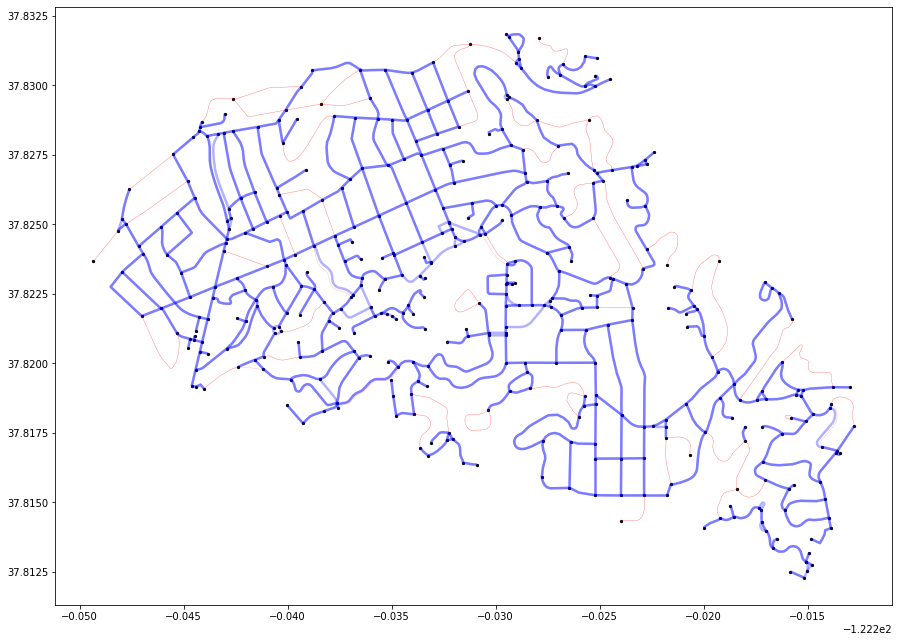

In [65]:
fig, ax =  plt.subplots(figsize=(15, 11))
ax.set_facecolor('w')
lines = []
colorS = []
widthS = []
for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data:
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
        if u in sources and v in destinations:
            colorS.append('b')
            widthS.append(2.5)
            continue
        if v in sources and u in destinations:
            colorS.append('b')
            widthS.append(2.5)
            continue
        colorS.append('r')
        widthS.append(0.4)
            

lc = LineCollection(lines, colors=colorS, linewidths=widthS, alpha=0.3)
ax.add_collection(lc)
scat = ax.scatter(node_Xs, node_Ys,c='k', s=5)